<a href="https://colab.research.google.com/github/Sevenc1over/AI-class/blob/main/10%EC%A3%BC%EC%B0%A8/%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%EC%9A%B0_CNN%2BGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)

    loaded = np.dstack(loaded)
    return loaded

def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

#스케일링
from sklearn.preprocessing import StandardScaler

# 원래 shape 저장
n_samples, n_timesteps, n_features = trainX.shape

# (7352*128, 9) 형태로 변환 — 모든 시점의 feature를 하나로 봄
scaler = StandardScaler()
trainX = scaler.fit_transform(trainX.reshape(-1, n_features)).reshape(n_samples, n_timesteps, n_features)
testX = scaler.transform(testX.reshape(-1, n_features)).reshape(testX.shape)

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

/tmp/ipython-input-3958942637.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3958942637.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3958942637.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-3958942637.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Conv1D, MaxPooling1D, Flatten

model = Sequential([
    Conv1D(32, 7, activation='relu', input_shape=(128, 9)),
    Conv1D(48, 5, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.3),
    Conv1D(48, 5, activation='relu'),
    Conv1D(32, 5, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.3),
    GRU(32, return_sequences=True),
    GRU(48, return_sequences=True),
    Dropout(0.3),
    GRU(48, return_sequences=True),
    GRU(32),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [3]:
#모델 컴파일하기
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [4]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 122, 32)        │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 118, 48)        │         7,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 59, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 59, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 55, 48)         │        11,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 51, 32)         │         7,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 25, 32)         │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 25, 48)         │        11,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 25, 48)         │        14,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         7,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,686 (280.02 KB)

 Trainable params: 71,686 (280.02 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 검증 손실(val_loss)이 5 에포크 동안 개선되지 않으면 학습률을 0.2배로 감소시키고, 최소 학습률은 0.0001로 설정합니다.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001, verbose=1)

In [6]:
# model_cnn_gru = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val) , batch_size=64, verbose=2) 인위적인 학습률 조정이 없는 코드
model_cnn_gru = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val) , batch_size=64, verbose=2, callbacks=[reduce_lr])

Epoch 1/50
92/92 - 20s - 219ms/step - accuracy: 0.6717 - loss: 0.8029 - val_accuracy: 0.8885 - val_loss: 0.2898 - learning_rate: 1.0000e-03
Epoch 2/50
92/92 - 8s - 82ms/step - accuracy: 0.9203 - loss: 0.2334 - val_accuracy: 0.9341 - val_loss: 0.1778 - learning_rate: 1.0000e-03
Epoch 3/50
92/92 - 9s - 100ms/step - accuracy: 0.9403 - loss: 0.1563 - val_accuracy: 0.9320 - val_loss: 0.1768 - learning_rate: 1.0000e-03
Epoch 4/50
92/92 - 9s - 100ms/step - accuracy: 0.9410 - loss: 0.1567 - val_accuracy: 0.9381 - val_loss: 0.1439 - learning_rate: 1.0000e-03
Epoch 5/50
92/92 - 9s - 94ms/step - accuracy: 0.9519 - loss: 0.1195 - val_accuracy: 0.9463 - val_loss: 0.1151 - learning_rate: 1.0000e-03
Epoch 6/50
92/92 - 9s - 102ms/step - accuracy: 0.9454 - loss: 0.1374 - val_accuracy: 0.9463 - val_loss: 0.1183 - learning_rate: 1.0000e-03
Epoch 7/50
92/92 - 10s - 111ms/step - accuracy: 0.9529 - loss: 0.1122 - val_accuracy: 0.9517 - val_loss: 0.1040 - learning_rate: 1.0000e-03
Epoch 8/50
92/92 - 9s - 93m

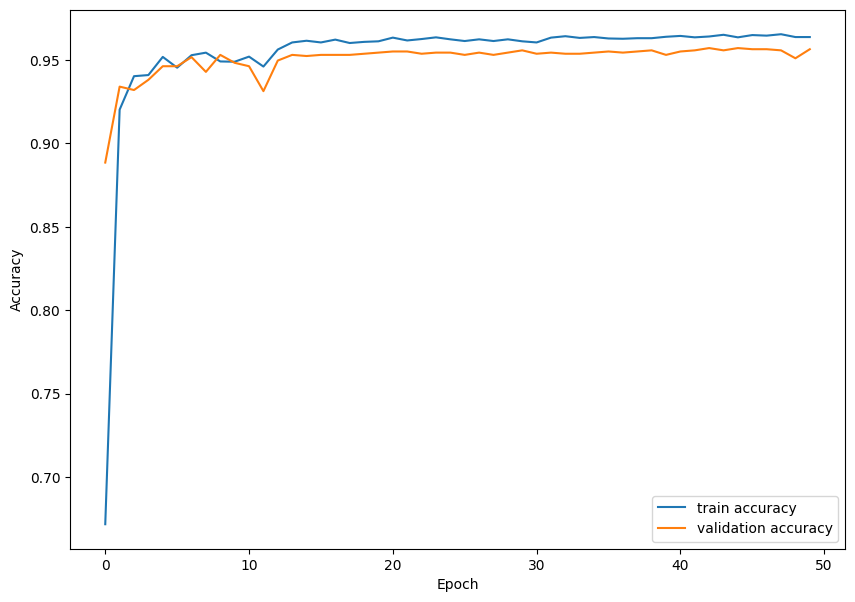

In [7]:
# loss 체크
import matplotlib.pyplot as plt

N_EPOCHS = 50 # 에포크 수 정의
history = model_cnn_gru # 학습 히스토리 변수 사용

plt.figure(figsize=(10,7))
plt.plot(range(N_EPOCHS), history.history['accuracy'], label='train accuracy')
plt.plot(range(N_EPOCHS), history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

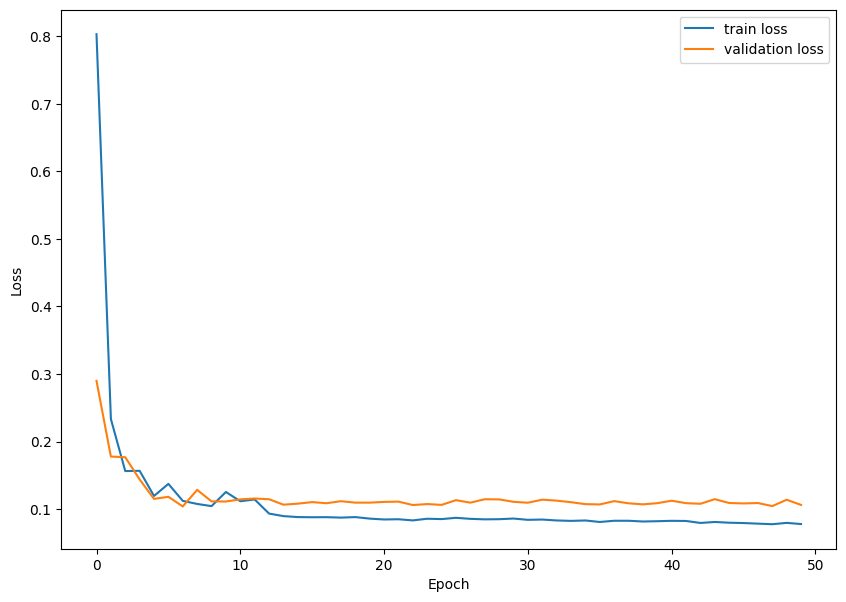

In [8]:
# loss 체크
import matplotlib.pyplot as plt

N_EPOCHS = 50 # 에포크 수 정의
history = model_cnn_gru # 학습 히스토리 변수 사용

plt.figure(figsize=(10,7))
plt.plot(range(N_EPOCHS), history.history['loss'], label='train loss')
plt.plot(range(N_EPOCHS), history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
test_loss, test_acc = model.evaluate(testX, testy)
print(f"Test accuracy: {test_acc:.2%}")

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8751 - loss: 0.4240
Test accuracy: 92.03%
